In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt

In [3]:
#actually. i should do the splitting after this preprocessing 

def load_ecg(ecg_file, window_size=30):
    df = pd.read_csv(ecg_file)

    fs = 256

    # Standardize ECG data
    ecg_scaler = StandardScaler()
    df['ECG'] = ecg_scaler.fit_transform(df['ECG'].values.reshape(-1, 1))

    data = []
    for idx in range(len(df) // (fs * window_size)):
        start_window = window_size * idx * fs
        
        ecg = df['ECG'].iloc[start_window:start_window + window_size * fs].values
        labels = df['psg_status'].iloc[start_window]
        if labels in [2, 3]:
            labels = 2
        elif labels in [4, 5]:
            labels = 3


        data.append((ecg, labels))

    return data


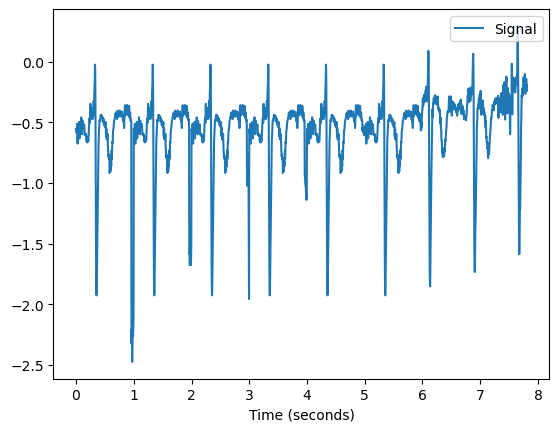

In [4]:
test_data = pd.read_csv('mesa_preproc/final/subject_0002_ecg.csv')


#data[window][0 = ecg data, 1 = label from 0 to 4]
fs = 256
test_ecg = test_data.ECG
nk.signal_plot(test_ecg[0:2000],sampling_rate = fs)


In [5]:
len(test_data)

7925760

In [6]:
# Define a new function
def my_processing(ecg_signal,fs):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs, method="neurokit")
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
    rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=fs)
    edr = nk.ecg_rsp(rate, sampling_rate=fs)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality,
                            "EDR": edr})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks

    return signals, info

In [7]:

ecg_proc,info = my_processing(test_ecg,fs)
ecg_proc


,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,EDR,ECG_R_Peaks
0,-0.555657,0.011241,67.142896,0.987816,-21.249673,0
1,-0.561913,0.009521,67.142896,0.987816,-21.223578,0
2,-0.585718,0.005477,67.142896,0.987816,-21.196621,0
3,-0.581140,0.000066,67.142896,0.987816,-21.168798,0
4,-0.541009,-0.003855,67.142896,0.987816,-21.140105,0
...,...,...,...,...,...,...
7925755,5.000000,0.067362,126.942149,0.000000,-0.009156,0
7925756,4.996338,0.053773,126.942149,0.000000,-0.007799,0
7925757,4.950866,0.043201,126.942149,0.000000,-0.006582,0
7925758,4.994202,0.036161,126.942149,0.000000,-0.005497,0


In [8]:
ecg_proc['labels'] = test_data['psg_status']
ecg_proc

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,EDR,ECG_R_Peaks,labels
0,-0.555657,0.011241,67.142896,0.987816,-21.249673,0,0
1,-0.561913,0.009521,67.142896,0.987816,-21.223578,0,0
2,-0.585718,0.005477,67.142896,0.987816,-21.196621,0,0
3,-0.581140,0.000066,67.142896,0.987816,-21.168798,0,0
4,-0.541009,-0.003855,67.142896,0.987816,-21.140105,0,0
...,...,...,...,...,...,...,...
7925755,5.000000,0.067362,126.942149,0.000000,-0.009156,0,0
7925756,4.996338,0.053773,126.942149,0.000000,-0.007799,0,0
7925757,4.950866,0.043201,126.942149,0.000000,-0.006582,0,0
7925758,4.994202,0.036161,126.942149,0.000000,-0.005497,0,0


In [9]:
len(ecg_proc)

7925760

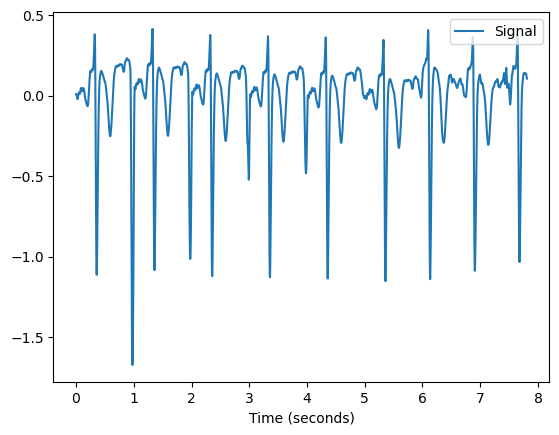

In [10]:
nk.signal_plot(ecg_proc.ECG_Clean[0:2000],sampling_rate = fs)


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,893.616503,86.911148,68.621407,34.065666,66.62778,38.75356,63.514545,44.410842,47.328641,47.329324,...,101.5625,1.836333,828.125,957.03125,1.858854,10.093809,304.6875,2074.21875,16.752901,0.0


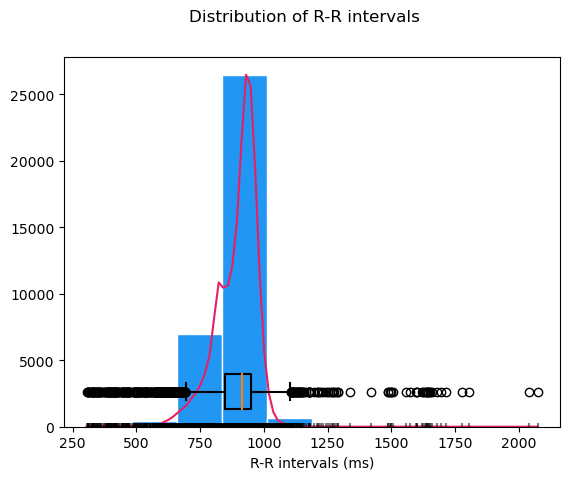

In [11]:

nk.hrv_time(ecg_proc.ECG_R_Peaks,fs,show = True)


In [12]:
window = 30 
intervals = numbers = np.arange(0, len(ecg_proc)-1, fs*window)
epochs = nk.epochs_create(ecg_proc, events=intervals, sampling_rate=fs)
epochs

{'1':             ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality        EDR  \
 0.000000  -0.555657   0.011241  67.142896     0.987816 -21.249673   
 0.003907  -0.561913   0.009521  67.142896     0.987816 -21.223578   
 0.007814  -0.585718   0.005477  67.142896     0.987816 -21.196621   
 0.011720  -0.581140   0.000066  67.142896     0.987816 -21.168798   
 0.015627  -0.541009  -0.003855  67.142896     0.987816 -21.140105   
 ...             ...        ...        ...          ...        ...   
 29.984373  0.070726   0.077749  69.939335     0.998654  -1.286031   
 29.988280  0.065843   0.081955  69.947225     0.998647  -1.280065   
 29.992186  0.064927   0.086197  69.955147     0.998641  -1.274090   
 29.996093  0.077287   0.090609  69.963098     0.998634  -1.268106   
 30.000000  0.084154   0.093862  69.971079     0.998628  -1.262112   
 
            ECG_R_Peaks  labels  Index Label  
 0.000000             0       0      0     1  
 0.003907             0       0      1     1  
 0.007814   

In [13]:
len(intervals)

1032

In [14]:
epochs_df = nk.epochs_to_df(epochs)
epochs_df = epochs_df[0:len(ecg_proc)]
#why did this double the amount of data LMAO is there overlap? i think it's a bug
epochs_df


,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,EDR,ECG_R_Peaks,labels,Index,Label,Time
0,-0.555657,0.011241,67.142896,0.987816,-21.249673,0,0,0,1,0.000000
1,-0.561913,0.009521,67.142896,0.987816,-21.223578,0,0,1,1,0.003907
2,-0.585718,0.005477,67.142896,0.987816,-21.196621,0,0,2,1,0.007814
3,-0.581140,0.000066,67.142896,0.987816,-21.168798,0,0,3,1,0.011720
4,-0.541009,-0.003855,67.142896,0.987816,-21.140105,0,0,4,1,0.015627
...,...,...,...,...,...,...,...,...,...,...
7925755,5.000000,0.067362,126.942149,0.000000,-0.009156,0,0,7925755,1032,29.980473
7925756,4.996338,0.053773,126.942149,0.000000,-0.007799,0,0,7925756,1032,29.984379
7925757,4.950866,0.043201,126.942149,0.000000,-0.006582,0,0,7925757,1032,29.988285
7925758,4.994202,0.036161,126.942149,0.000000,-0.005497,0,0,7925758,1032,29.992191


In [15]:
epochs_df[epochs_df.Label.astype(int) == 1031]

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,EDR,ECG_R_Peaks,labels,Index,Label,Time
7910400,4.959411,3.616162,76.489897,0.712528,20.760587,0,0,7910400,1031,0.000000
7910401,5.000000,3.617423,76.810501,0.715816,20.957621,0,0,7910401,1031,0.003907
7910402,5.000000,3.618651,77.160148,0.719163,21.154089,0,0,7910402,1031,0.007814
7910403,5.000000,3.619847,77.538790,0.722569,21.349978,0,0,7910403,1031,0.011720
7910404,4.965972,3.615445,77.946421,0.726034,21.545270,0,0,7910404,1031,0.015627
...,...,...,...,...,...,...,...,...,...,...
7918075,-4.288167,-4.956472,82.587702,0.622883,-0.517922,0,0,7918075,1031,29.984373
7918076,-4.216907,-4.983096,83.123501,0.620267,-0.355550,0,0,7918076,1031,29.988280
7918077,-5.000000,-5.026273,83.664582,0.617667,-0.193304,0,0,7918077,1031,29.992186
7918078,-5.000000,-5.045542,84.210792,0.615084,-0.031191,0,0,7918078,1031,29.996093


In [37]:
feat = nk.ecg_intervalrelated(epochs)
feat.head()

/Users/bojing/anaconda3/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/bojing/anaconda3/lib/python3.11/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/bojing/anaconda3/lib/python3.11/site-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/Users/bojing/anaconda3/lib/python3.11/site-packages/neurokit2/complexity/entropy

,Label,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
1,1,80.436524,[[192.30769230769232]],[[32.986563329996756]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.19159519357928373]],[[3.9872178475009483]],[[0.3962957470978708]],[[0.10699599291087852]],[[0.12007946228324423]],[[0.1198193165077662]],[[0.6911891569356629]],[[1.8488739370792746]],[[2.043572263408112]],[[0.9486619367188652]]
2,2,75.931858,[[201.86486486486487]],[[4.441985055268785]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[inf]],[[3.5465942457551543]],[[1.1814746069012365]],[[nan]],[[nan]],[[nan]],[[1.9470504879480297]],[[1.7247945099999666]],[[1.541587557451127]],[[0.9855722583622337]]
3,3,77.015533,[[199.27027027027026]],[[2.3051711029365727]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[2.0149030205422647]],[[2.806484029937474]],[[1.2743614639051624]],[[0.0]],[[0.8169164972594082]],[[0.8797451043296347]],[[2.0649857020617]],[[1.8367088084939276]],[[2.2430590818506104]],[[0.7039801845444527]]
4,4,78.317247,[[196.0]],[[6.223892841723993]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.8209805520698301]],[[4.079772731460867]],[[0.9318229268045018]],[[0.0]],[[0.0]],[[0.0]],[[1.8246651702830892]],[[1.4730123299471518]],[[1.9580043694954212]],[[0.5420925352679229]]
5,5,77.648963,[[198.16216216216216]],[[6.153199319204754]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.8649974374866046]],[[3.8747485552166756]],[[0.7944328368551894]],[[0.5294401014954931]],[[0.6327749231435517]],[[0.6186088374801763]],[[1.8875760331274267]],[[1.5415323382133652]],[[1.4969158020943067]],[[0.5631841476355621]]


In [38]:
feat

,Label,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
1,1,80.436524,[[192.30769230769232]],[[32.986563329996756]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.19159519357928373]],[[3.9872178475009483]],[[0.3962957470978708]],[[0.10699599291087852]],[[0.12007946228324423]],[[0.1198193165077662]],[[0.6911891569356629]],[[1.8488739370792746]],[[2.043572263408112]],[[0.9486619367188652]]
2,2,75.931858,[[201.86486486486487]],[[4.441985055268785]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[inf]],[[3.5465942457551543]],[[1.1814746069012365]],[[nan]],[[nan]],[[nan]],[[1.9470504879480297]],[[1.7247945099999666]],[[1.541587557451127]],[[0.9855722583622337]]
3,3,77.015533,[[199.27027027027026]],[[2.3051711029365727]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[2.0149030205422647]],[[2.806484029937474]],[[1.2743614639051624]],[[0.0]],[[0.8169164972594082]],[[0.8797451043296347]],[[2.0649857020617]],[[1.8367088084939276]],[[2.2430590818506104]],[[0.7039801845444527]]
4,4,78.317247,[[196.0]],[[6.223892841723993]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.8209805520698301]],[[4.079772731460867]],[[0.9318229268045018]],[[0.0]],[[0.0]],[[0.0]],[[1.8246651702830892]],[[1.4730123299471518]],[[1.9580043694954212]],[[0.5420925352679229]]
5,5,77.648963,[[198.16216216216216]],[[6.153199319204754]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.8649974374866046]],[[3.8747485552166756]],[[0.7944328368551894]],[[0.5294401014954931]],[[0.6327749231435517]],[[0.6186088374801763]],[[1.8875760331274267]],[[1.5415323382133652]],[[1.4969158020943067]],[[0.5631841476355621]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,1028,88.744252,[[180.6829268292683]],[[90.31041994819597]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[inf]],[[5.0952376752970245]],[[1.6639648954278172]],[[0.0]],[[0.0]],[[0.0]],[[1.7324646810765438]],[[1.9835665790681343]],[[3.0214760939981486]],[[1.437392001238998]]
1029,1029,102.479270,[[151.6734693877551]],[[54.101905294199995]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[inf]],[[5.354406017540444]],[[1.523908294568459]],[[nan]],[[0.0]],[[0.0]],[[1.88307712397304]],[[1.9859446169430104]],[[3.2393749478477916]],[[1.031273236674222]]
1030,1030,105.033645,[[152.32]],[[60.105499086258014]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[1.8382794848629478]],[[5.323856189774725]],[[1.5412832961907217]],[[0.7342229433827644]],[[1.2981536729084457]],[[1.4718824346326513]],[[1.5417017366767842]],[[1.9484430889936022]],[[3.5743852604361375]],[[1.2416483617504392]]
1031,1031,88.976350,[[179.14285714285714]],[[69.7611155330684]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[1.791759469228055]],[[5.297079327540665]],[[1.4441136055677655]],[[0.0]],[[0.0]],[[0.0]],[[2.036962428307691]],[[1.9439379318074046]],[[2.558280798627735]],[[1.2838851006616097]]


In [41]:
# Define columns for which to un-bracket values
columns_to_unbracket = feat.columns[2:]

# Un-bracket the values for selected columns twice
for col in columns_to_unbracket:
    feat[col] = feat[col].apply(lambda x: x[0][0])

# Display the resulting DataFrame
feat


,Label,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
1,1,80.436524,192.307692,32.986563,NaN,NaN,NaN,NaN,NaN,NaN,...,0.191595,3.987218,0.396296,0.106996,0.120079,0.119819,0.691189,1.848874,2.043572,0.948662
2,2,75.931858,201.864865,4.441985,NaN,NaN,NaN,NaN,NaN,NaN,...,inf,3.546594,1.181475,NaN,NaN,NaN,1.947050,1.724795,1.541588,0.985572
3,3,77.015533,199.270270,2.305171,NaN,NaN,NaN,NaN,NaN,NaN,...,2.014903,2.806484,1.274361,0.000000,0.816916,0.879745,2.064986,1.836709,2.243059,0.703980
4,4,78.317247,196.000000,6.223893,NaN,NaN,NaN,NaN,NaN,NaN,...,0.820981,4.079773,0.931823,0.000000,0.000000,0.000000,1.824665,1.473012,1.958004,0.542093
5,5,77.648963,198.162162,6.153199,NaN,NaN,NaN,NaN,NaN,NaN,...,0.864997,3.874749,0.794433,0.529440,0.632775,0.618609,1.887576,1.541532,1.496916,0.563184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,1028,88.744252,180.682927,90.310420,NaN,NaN,NaN,NaN,NaN,NaN,...,inf,5.095238,1.663965,0.000000,0.000000,0.000000,1.732465,1.983567,3.021476,1.437392
1029,1029,102.479270,151.673469,54.101905,NaN,NaN,NaN,NaN,NaN,NaN,...,inf,5.354406,1.523908,NaN,0.000000,0.000000,1.883077,1.985945,3.239375,1.031273
1030,1030,105.033645,152.320000,60.105499,NaN,NaN,NaN,NaN,NaN,NaN,...,1.838279,5.323856,1.541283,0.734223,1.298154,1.471882,1.541702,1.948443,3.574385,1.241648
1031,1031,88.976350,179.142857,69.761116,NaN,NaN,NaN,NaN,NaN,NaN,...,1.791759,5.297079,1.444114,0.000000,0.000000,0.000000,2.036962,1.943938,2.558281,1.283885


In [19]:
for col in feat.columns:
    print(col)

Label
ECG_Rate_Mean
HRV_MeanNN
HRV_SDNN
HRV_SDANN1
HRV_SDNNI1
HRV_SDANN2
HRV_SDNNI2
HRV_SDANN5
HRV_SDNNI5
HRV_RMSSD
HRV_SDSD
HRV_CVNN
HRV_CVSD
HRV_MedianNN
HRV_MadNN
HRV_MCVNN
HRV_IQRNN
HRV_SDRMSSD
HRV_Prc20NN
HRV_Prc80NN
HRV_pNN50
HRV_pNN20
HRV_MinNN
HRV_MaxNN
HRV_HTI
HRV_TINN
HRV_ULF
HRV_VLF
HRV_LF
HRV_HF
HRV_VHF
HRV_TP
HRV_LFHF
HRV_LFn
HRV_HFn
HRV_LnHF
HRV_SD1
HRV_SD2
HRV_SD1SD2
HRV_S
HRV_CSI
HRV_CVI
HRV_CSI_Modified
HRV_PIP
HRV_IALS
HRV_PSS
HRV_PAS
HRV_GI
HRV_SI
HRV_AI
HRV_PI
HRV_C1d
HRV_C1a
HRV_SD1d
HRV_SD1a
HRV_C2d
HRV_C2a
HRV_SD2d
HRV_SD2a
HRV_Cd
HRV_Ca
HRV_SDNNd
HRV_SDNNa
HRV_DFA_alpha1
HRV_MFDFA_alpha1_Width
HRV_MFDFA_alpha1_Peak
HRV_MFDFA_alpha1_Mean
HRV_MFDFA_alpha1_Max
HRV_MFDFA_alpha1_Delta
HRV_MFDFA_alpha1_Asymmetry
HRV_MFDFA_alpha1_Fluctuation
HRV_MFDFA_alpha1_Increment
HRV_ApEn
HRV_SampEn
HRV_ShanEn
HRV_FuzzyEn
HRV_MSEn
HRV_CMSEn
HRV_RCMSEn
HRV_CD
HRV_HFD
HRV_KFD
HRV_LZC


In [20]:
#last thing to do: add lables: 
labels = test_data.psg_status.to_frame()
labels

,psg_status
0,0
1,0
2,0
3,0
4,0
...,...
7925755,0
7925756,0
7925757,0
7925758,0


In [21]:
labels.psg_status.unique()

array([0, 1, 2, 3, 5])

In [22]:
epochs_df['labels'] = labels['psg_status']

In [23]:
# binary classification
epochs_df['labels2'] = labels['psg_status'].replace([1, 2, 3, 4, 5], 1)

In [24]:

epochs_df['labels4'] = labels['psg_status'].replace([1,2], 1)
epochs_df['labels4'] = epochs_df['labels4'].replace([3,4], 2)
epochs_df['labels4'] = epochs_df['labels4'].replace([5], 3)

In [25]:
epochs_df.labels4.unique()

array([0, 1, 2, 3])

In [26]:
labels.groupby('psg_status').size()

psg_status
0    2181120
1     376320
2    2780160
3    1198080
5    1390080
dtype: int64

In [27]:

epochs_df.groupby('labels4').size()
epochs_df.groupby('labels2').size()

labels2
0    2181120
1    5744640
dtype: int64

In [28]:
labels_trunc = labels.iloc[::256*30, :].reset_index()
len(labels_trunc)

1032

In [29]:
labels_trunc['psg_status']


0       0
1       0
2       0
3       0
4       0
       ..
1027    0
1028    0
1029    0
1030    0
1031    0
Name: psg_status, Length: 1032, dtype: int64

In [30]:
feat['labels'] = labels_trunc['psg_status'].values

feat['labels2'] = feat['labels'].replace([1, 2, 3, 4, 5], 1).values

feat['labels4'] = feat['labels'].replace([1,2], 1).values
feat['labels4'] = feat['labels4'].replace([3,4], 2).values
feat['labels4'] = feat['labels4'].replace([5], 3).values


In [31]:
feat.groupby('labels4').size()

labels4
0    284
1    411
2    156
3    181
dtype: int64

In [32]:
feat.to_csv('feat_0002.csv')
epochs_df.to_csv('ecg_proc_0002.csv')

KeyboardInterrupt: 

In [ ]:

rsp, info = nk.rsp_process(ecg_proc.EDR,sampling_rate=fs)
rsp


In [ ]:
nk.signal_plot(rsp.RSP_Raw[0:2000],sampling_rate = fs)
nk.signal_plot(rsp.RSP_Clean[0:2000],sampling_rate = fs)

In [ ]:
ah = nk.rsp_intervalrelated(rsp,sampling_rate=fs)


ah

In [ ]:
ecg_proc.EDR.to_frame()